# LSTM Example

LSTM is a neural network architecture useful for machine learning tasks involving sequences with long-term dependencies. In our example, we will illustrate the basics of using an LSTM architecture by training on a single protein sequence of alemtuzumab. In particular, we borrow an example of protein sequencing prediction from the paper "De novo protein sequencing by combining top-down and bottom-up tandem mass spectra".

In that paper, we see this image: 

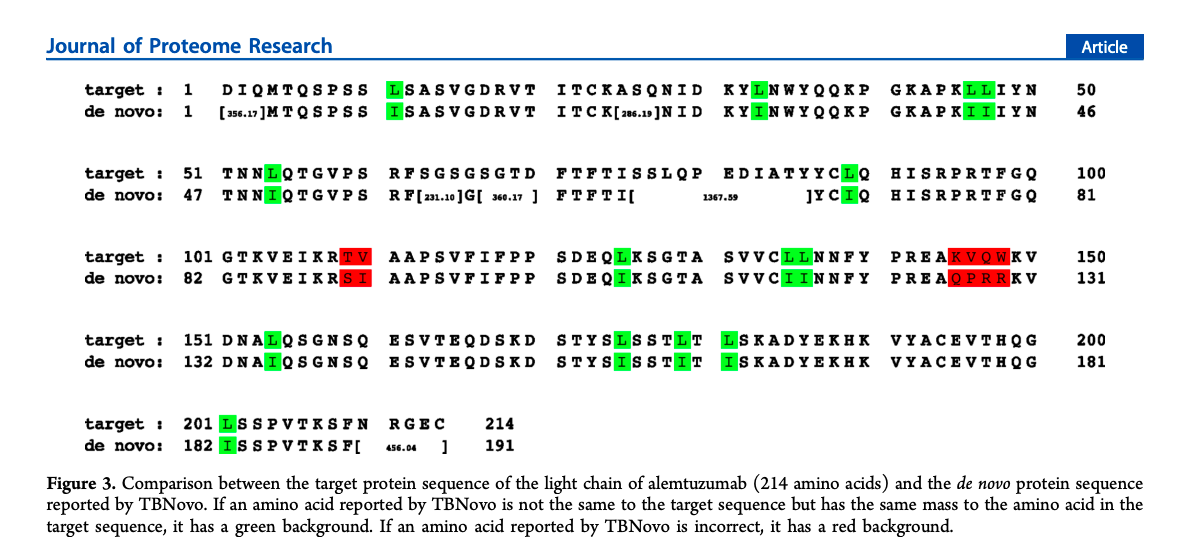


Our task then is this: train an LSTM model that can predict, with high accuracy, the missing gaps. In other words, the missing gaps represent our **test_data**. Those gaps are those parts of the de-novo sequence with characters inside the brackets `[]`.

Our strategy will be to split this sequence into a set of `Kmers` that predict the next `i` character. All those instances where `i` is one of our missing elements in the de-novo sequence will be the test instances. Everything else will be the training instances. 

Lets get started by first doing the usual imports:

In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D
from keras.utils import np_utils

# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


Now, we define the dataset. We retrieved this protein sequence online, then we manually added gaps that correspond to the gaps in our image by defining a set of `missing_indices`. Then, the de_novo_sequence will be the same thing as our full sequence with those indices removed:

In [2]:
# define the raw dataset
missing_indices = set([0, 1, 2, 24, 25, 26, 62, 63, 64, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 209, 210, 211, 212, 213])
target_sequence = "DIQMTQSPSSLSASVGDRVTITCKASQNIDKYLNWYQQKPGKAPKLLIYNTNNLQTGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCLQHISRPRTFGQGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGEC"
de_novo_sequence = "".join(char if i not in missing_indices else "-" for i, char in enumerate(target_sequence))

To see whether we've got the right sequence, we wrote a function that prints the sequence in a readable way. We can inspect to confirm it matches the image we borrowed from the above paper:

In [3]:
def print_sequence(seq):
	print("=====================================================================")
	line_length = 50
	group_length = 10
	lines = [seq[begin:begin+line_length] for begin in range(0, len(seq), line_length)]
	for line in lines:
		groups = [line[begin:begin+group_length] for begin in range(0, len(line), group_length)]
		print("\t".join(groups))

print_sequence(target_sequence)
print_sequence(de_novo_sequence)

DIQMTQSPSS	LSASVGDRVT	ITCKASQNID	KYLNWYQQKP	GKAPKLLIYN
TNNLQTGVPS	RFSGSGSGTD	FTFTISSLQP	EDIATYYCLQ	HISRPRTFGQ
GTKVEIKRTV	AAPSVFIFPP	SDEQLKSGTA	SVVCLLNNFY	PREAKVQWKV
DNALQSGNSQ	ESVTEQDSKD	STYSLSSTLT	LSKADYEKHK	VYACEVTHQG
LSSPVTKSFN	RGEC
---MTQSPSS	LSASVGDRVT	ITCK---NID	KYLNWYQQKP	GKAPKLLIYN
TNNLQTGVPS	RF---G----	FTFTI-----	------YCLQ	HISRPRTFGQ
GTKVEIKRTV	AAPSVFIFPP	SDEQLKSGTA	SVVCLLNNFY	PREAKVQWKV
DNALQSGNSQ	ESVTEQDSKD	STYSLSSTLT	LSKADYEKHK	VYACEVTHQG
LSSPVTKSF-	----


We need to encode our character data into a numerical form, so we create a mapping of integers to characters that we will use when we generate our dataset.

In [4]:
# create mapping of characters to integers and the reverse
char_to_int = dict((c, i) for i, c in enumerate(set(target_sequence)))
int_to_char = {v: k for k, v in char_to_int.items()}

Next, we choose a value for K to indicate the length of the subsequences we will generate. K here also indicates the time-step we are choosing.

In [5]:
# Length of Kmer / time-steps in our dataset
kmer_length = 10

Now we need to generate our dataset from this single sequence of alemtuzumab. We have chosen a `kmer_length` of 3. This means that we need to generate all input-output pairs like so:

$ [c_{k-3}, c_{k-2}, c_{k-1}] -> c_k$

In other words, each character, $c_k$, in our sequence is an output produced by the previous three characters in the sequence. To perform our training / test split, once we generate all input-output pairs, we select for test data those instances where the target output character, $c_k$, is a missing character in the de-novo sequence above.

In [6]:
train_as_lstX = []
train_as_lstY = []
test_as_lstX = []
test_as_lstY = []

train_output_to_input = {}
test_output_to_input = {}

# Iterate over entire target sequence, starting at kmer_length to ignore first kmer_length characters
for index in range(kmer_length, len(target_sequence)):
	seq_in = target_sequence[index - kmer_length:index]
	seq_out = target_sequence[index]

	if index in missing_indices:
		# We are adding the missing ones to the test_as_lst set
		test_as_lstX.append([char_to_int[char] for char in seq_in])
		test_as_lstY.append(char_to_int[seq_out])
		test_output_to_input.setdefault(seq_out, []).append(seq_in)
	else:
		# Non missing ones are used for train_as_lsting
		train_as_lstX.append([char_to_int[char] for char in seq_in])
		train_as_lstY.append(char_to_int[seq_out])
		train_output_to_input.setdefault(seq_out, []).append(seq_in)

print("SEEING TEST INPUTS VERSUS TRAIN INPUTS FOR EACH OUTPUT")
print("========================================================")
for out, inp in test_output_to_input.items():
	print(f"TEST : {out} -> {inp}")
	print(f"TRAIN: {out} -> {train_output_to_input.get(out)}\n")

SEEING TEST INPUTS VERSUS TRAIN INPUTS FOR EACH OUTPUT
TEST : A -> ['VGDRVTITCK', 'TISSLQPEDI']
TRAIN: A -> ['QMTQSPSSLS', 'LNWYQQKPGK', 'GTKVEIKRTV', 'TKVEIKRTVA', 'PSDEQLKSGT', 'CLLNNFYPRE', 'EAKVQWKVDN', 'SLSSTLTLSK', 'KADYEKHKVY']

TEST : S -> ['GDRVTITCKA', 'NLQTGVPSRF', 'QTGVPSRFSG', 'GVPSRFSGSG', 'GSGTDFTFTI', 'SGTDFTFTIS']
TRAIN: S -> ['IQMTQSPSSL', 'MTQSPSSLSA', 'NTNNLQTGVP', 'IATYYCLQHI', 'VEIKRTVAAP', 'AAPSVFIFPP', 'IFPPSDEQLK', 'SDEQLKSGTA', 'VQWKVDNALQ', 'KVDNALQSGN', 'NALQSGNSQE', 'NSQESVTEQD', 'ESVTEQDSKD', 'TEQDSKDSTY', 'QDSKDSTYSL', 'DSKDSTYSLS', 'TYSLSSTLTL', 'YACEVTHQGL', 'ACEVTHQGLS', 'HQGLSSPVTK']

TEST : Q -> ['DRVTITCKAS', 'TDFTFTISSL']
TRAIN: Q -> ['QNIDKYLNWY', 'NIDKYLNWYQ', 'KLLIYNTNNL', 'PEDIATYYCL', 'QHISRPRTFG', 'SVFIFPPSDE', 'NNFYPREAKV', 'KVQWKVDNAL', 'VDNALQSGNS', 'SGNSQESVTE', 'HKVYACEVTH']

TEST : G -> ['LQTGVPSRFS', 'VPSRFSGSGS', 'SSPVTKSFNR']
TRAIN: G -> ['QSPSSLSASV', 'KYLNWYQQKP', 'LIYNTNNLQT', 'TGVPSRFSGS', 'LQHISRPRTF', 'HISRPRTFGQ', 'FPPSDEQLKS'

The LSTM model requires our training and test data to be reshaped. In particular, it's important that we reshape the data to incorporate the **time step** we have chosen, our in case a time step of 3.

In [7]:
# reshape X to be [samples, time steps, features]
trainX = numpy.reshape(train_as_lstX, (len(train_as_lstX), kmer_length, 1))
testX = numpy.reshape(test_as_lstX, (len(test_as_lstX), kmer_length, 1))
trainX[0]

array([[ 3],
       [14],
       [ 8],
       [ 6],
       [13],
       [ 8],
       [17],
       [12],
       [17],
       [17]])

Next, we normalize our data to speed training:

In [8]:
# normalize (leng)
trainX = trainX / float(len(char_to_int))
testX = testX / float(len(char_to_int))
trainX[0]

array([[0.15],
       [0.7 ],
       [0.4 ],
       [0.3 ],
       [0.65],
       [0.4 ],
       [0.85],
       [0.6 ],
       [0.85],
       [0.85]])

We one-hot encode the output variable so that we can perform classification. In other words, our output will be a vector of length N, where N = number of unique characters in our string. The vector will have all 0s except a single 1 to indicate which character it represents.

In [9]:
# one hot encode the output variable
trainY = np_utils.to_categorical(train_as_lstY)
testY = np_utils.to_categorical(test_as_lstY)
print("First training output: %s" % int_to_char[train_as_lstY[0]])
print("Integer representation of training output: %s" % train_as_lstY[0])
print("We would expect 1 value in index %s" % train_as_lstY[0])
trainY[0]

First training output: L
Integer representation of training output: 4
We would expect 1 value in index 4


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

Next, we specify our model hyperparameters. We have several choices to make for our model. We must select `num_epochs`, the number of epochs to train (we select 10 to for the purposes of efficient presentation). We must choose, `num_lstm_layers` the width of the hidden layers inside each LSTM cell. We also have to choose `cost_func` and `optimizer`, the cost function and optimizer algorithm respectively. We choose categorical cross entropy as the cost function, since this function is useful for multiclass classification tasks. We choose adam (aka. Adaptive Moment Estimation) as a default optimizer algorithm. Finally, we must choose `output_activation_func`, an activation function for the output layer, an obvious choice being softmax.

In [10]:
epoch_length = 100
num_lstm_layers = 256
first_conv_filters = 128
first_conv_kernel_size = 5
#second_conv_layer = 500
first_dense_layer = 128
second_dense_layer = 64
cost_func = "categorical_crossentropy"
optimizer = "adam"
output_activation_func = "softmax"
hidden_layer_activation_func = "relu"

Finally, we create the architecture of our neural network by adding a single LSTM layer, connected densely to the final output layer with the softmax activation function. The loss function will be categorical_crossentropy, useful for multiclass classification tasks. The optimizer will be be adam (Adaptive Moment Estimation), a variant of gradient descent.

In [11]:
# create the model


model = Sequential()
model.add(Conv1D(first_conv_filters, first_conv_kernel_size))
model.add(LSTM(num_lstm_layers, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(first_dense_layer, activation=hidden_layer_activation_func))
model.add(Dense(second_dense_layer, activation=hidden_layer_activation_func))
model.add(Dense(trainY.shape[1], activation=output_activation_func))
model.compile(loss=cost_func, optimizer=optimizer, metrics=['accuracy'])

#Conv1D_1 (None, 1000, 128) 3200
#MaxPooling1D_1 (None, 500, 128) 0
#Conv1D_2 (None, 500, 64) 24640
#MaxPooling_2 (None, 250, 64) 0
#Flatten (None, 16) 0
#Dense_1 (None, 128) 2176
#Dense_2 (None, 64) 8256
#Dense_3 (None, 6) 390

2022-03-01 09:39:13.023122: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 09:39:13.023506: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# fit the data, summarize performance of the model
model.fit(trainX, trainY, epochs=epoch_length, batch_size=1, verbose=2, validation_data=(testX, testY))
scores = model.evaluate(trainX, trainY, verbose=0)
final_accuracy = "%.2f%%" % (scores[1]*100)
print(final_accuracy)

Train on 178 samples, validate on 26 samples
Epoch 1/100
 - 16s - loss: 2.9953 - accuracy: 0.0899 - val_loss: 2.9219 - val_accuracy: 0.2308
Epoch 2/100
 - 8s - loss: 2.9155 - accuracy: 0.0843 - val_loss: 2.9029 - val_accuracy: 0.2308
Epoch 3/100
 - 8s - loss: 2.8879 - accuracy: 0.1011 - val_loss: 2.8456 - val_accuracy: 0.2308
Epoch 4/100
 - 8s - loss: 2.8692 - accuracy: 0.0955 - val_loss: 2.8781 - val_accuracy: 0.1154
Epoch 5/100
 - 8s - loss: 2.8476 - accuracy: 0.0787 - val_loss: 2.8667 - val_accuracy: 0.1923
Epoch 6/100
 - 8s - loss: 2.8745 - accuracy: 0.1180 - val_loss: 2.9389 - val_accuracy: 0.1538
Epoch 7/100
 - 8s - loss: 2.8419 - accuracy: 0.0955 - val_loss: 2.8704 - val_accuracy: 0.1538
Epoch 8/100
 - 9s - loss: 2.8085 - accuracy: 0.1124 - val_loss: 2.8570 - val_accuracy: 0.1923
Epoch 9/100
 - 8s - loss: 2.7814 - accuracy: 0.0955 - val_loss: 2.9127 - val_accuracy: 0.1538
Epoch 10/100
 - 8s - loss: 2.7755 - accuracy: 0.1067 - val_loss: 3.0322 - val_accuracy: 0.1154
Epoch 11/100


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 128)            768       
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 437,460
Trainable params: 437,460
Non-trainable params: 0
_________________________________________________________________
